Multivariate pykalman Example

by jayzer

Explanation
Simulation (Step 1): We simulate a 10-variable sensor dataset with injected NaNs to mimic real-world dropouts.

EM Data Preparation (Step 2): Since the EM algorithm in pykalman requires complete data, we fill in the missing values. This filled (imputed) data is used only for estimating the filter parameters.

Kalman Filter Training (Step 3): We initialize the Kalman Filter and run the EM algorithm on the complete (filled) data to automatically tune the filter parameters.

Smoothing with Missing Data (Step 4): For the actual smoothing step, we convert the original data (with NaNs) into a masked array so that missing observations are properly handled (i.e., skipped during updates). This is the recommended procedure per pykalman’s documentation on handling missing measurements.

Visualization (Step 5): Finally, we compare the true state, the noisy observations, and the Kalman-smoothed estimates (for one variable) to see how effective the smoothing is.

In [ ]:
!pip install pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
"""
Enhanced Demo: Multivariate Kalman Filtering Using pykalman
-----------------------------------------------------------
This program:
1. Simulates synthetic multivariate sensor data (10 variables) with varying scales.
2. Introduces missing values (NaNs) to mimic real-world sensor dropouts.
3. Uses pykalman's EM algorithm on an imputed copy of the data (no NaNs)
   to calibrate the Kalman filter automatically.
4. Applies smoothing on the raw data (with NaNs) to clean the data.
5. Visualizes the results for one variable.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter




In [ ]:
# Step 1: Simulate Multivariate Sensor Data

np.random.seed(42)
n_timesteps = 100
n_variables = 10

# Simulate an underlying "true" state via a cumulative sum for each sensor variable
true_state = np.cumsum(np.random.randn(n_timesteps, n_variables), axis=0)

# Create noisy observations using different noise levels for each variable
noise_std = np.linspace(0.5, 2.0, n_variables)  # noise from 0.5 to 2.0
observations = true_state + np.random.randn(n_timesteps, n_variables) * noise_std

# Introduce missing values (simulate 10% dropout per element)
mask = np.random.rand(n_timesteps, n_variables) < 0.1
observations[mask] = np.nan

# Construct a DataFrame where each column represents a sensor variable
columns = [f"var_{i+1}" for i in range(n_variables)]
df = pd.DataFrame(observations, columns=columns)
df.index.name = 'time'

print("Head of Simulated DataFrame (with NaNs):")
print(df.head())


Head of Simulated DataFrame (with NaNs):
         var_1     var_2     var_3     var_4     var_5     var_6     var_7  \
time                                                                         
0     1.196392       NaN  0.697381  0.876093  0.580440  0.290510       NaN   
1          NaN -0.472261  2.619035 -1.079438       NaN       NaN -0.410745   
2     1.760363 -1.212237  0.936884  0.327272 -0.487987 -0.103737 -0.527607   
3     0.768550 -0.089882  1.276368 -2.225514 -2.244627  0.192303 -2.214397   
4     2.477669  0.887953  1.726934 -3.212322 -3.360830 -1.447977  0.142097   

         var_8     var_9    var_10  
time                                
0     1.826054  1.454706 -0.527910  
1     0.275206 -1.964802 -0.021412  
2     1.657432 -0.853354 -3.207023  
3    -2.942915       NaN  1.129620  
4    -2.072488 -0.255714  0.032566  


In [ ]:
# Step 2: Prepare Data for EM Parameter Estimation
df_filled = df.ffill().bfill()  # fill missing values using forward-fill then back-fill
data_for_em = df_filled.values

print("Head of Filled Data for EM Parameter Estimation:")
print(df_filled.head())


Head of Filled Data for EM Parameter Estimation:
         var_1     var_2     var_3     var_4     var_5     var_6     var_7  \
time                                                                         
0     1.196392 -0.472261  0.697381  0.876093  0.580440  0.290510 -0.410745   
1     1.196392 -0.472261  2.619035 -1.079438  0.580440  0.290510 -0.410745   
2     1.760363 -1.212237  0.936884  0.327272 -0.487987 -0.103737 -0.527607   
3     0.768550 -0.089882  1.276368 -2.225514 -2.244627  0.192303 -2.214397   
4     2.477669  0.887953  1.726934 -3.212322 -3.360830 -1.447977  0.142097   

         var_8     var_9    var_10  
time                                
0     1.826054  1.454706 -0.527910  
1     0.275206 -1.964802 -0.021412  
2     1.657432 -0.853354 -3.207023  
3    -2.942915 -0.853354  1.129620  
4    -2.072488 -0.255714  0.032566  


In [ ]:
# Step 3: Set Up and Train the Kalman Filter Using EM (on filled data)
# Initialize the Kalman Filter with dimensions equal to the number of variables
kf = KalmanFilter(n_dim_obs=n_variables, n_dim_state=n_variables)

# Calibrate the filter parameters by running EM on the filled data
kf = kf.em(data_for_em, n_iter=10)

print("Kalman Filter Object:")
print(kf)


Kalman Filter Object:


In [ ]:
# Step 4: Smooth the Data Using Masked Arrays for Missing Values
import numpy.ma as ma

# Convert the original DataFrame values (with NaNs) to a masked array.
# This converts all np.nan entries to masked values.
data_masked = ma.masked_invalid(df.values)


print("Head of Masked data:")
print(data_masked[0:10])

# Now run the Kalman smoother on the masked data; the filter will skip masked observations.
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(data_masked)

# Convert the resulting smoothed state means back into a DataFrame
smoothed_df = pd.DataFrame(smoothed_state_means, columns=columns, index=df.index)

print("Head of Smoothed DataFrame:")
print(smoothed_df.head())


Head of Masked data:
[[1.1963918713042339 -- 0.6973805130341709 0.8760930787024515
  0.5804404911591855 0.29051022361315215 -- 1.826054398622858
  1.4547055921504954 -0.5279103795351713]
 [-- -0.4722609849465084 2.619034870187781 -1.0794382063393404 -- --
  -0.41074531024870486 0.27520567165764676 -1.9648018598124166
  -0.021411764945494016]
 [1.7603629731380743 -1.212237024520363 0.9368835208038314
  0.32727178414863434 -0.4879868999773884 -0.10373700358157778
  -0.5276066649970347 1.6574322912909567 -0.8533542013692041
  -3.2070225379394146]
 [0.768550348179255 -0.08988155330409886 1.2763677251211158
  -2.225513563716389 -2.244626559007632 0.19230347126873415
  -2.214396781748092 -2.942914844135621 -- 1.129620433550829]
 [2.4776690426152723 0.8879532685583044 1.7269342017545557
  -3.212321668509126 -3.3608295266234123 -1.4479765048637885
  0.14209725941576212 -2.0724880792074205 -0.25571426954079524
  0.03256638125868916]
 [1.6470078155263683 1.0726628523462205 0.5628033288247996 --


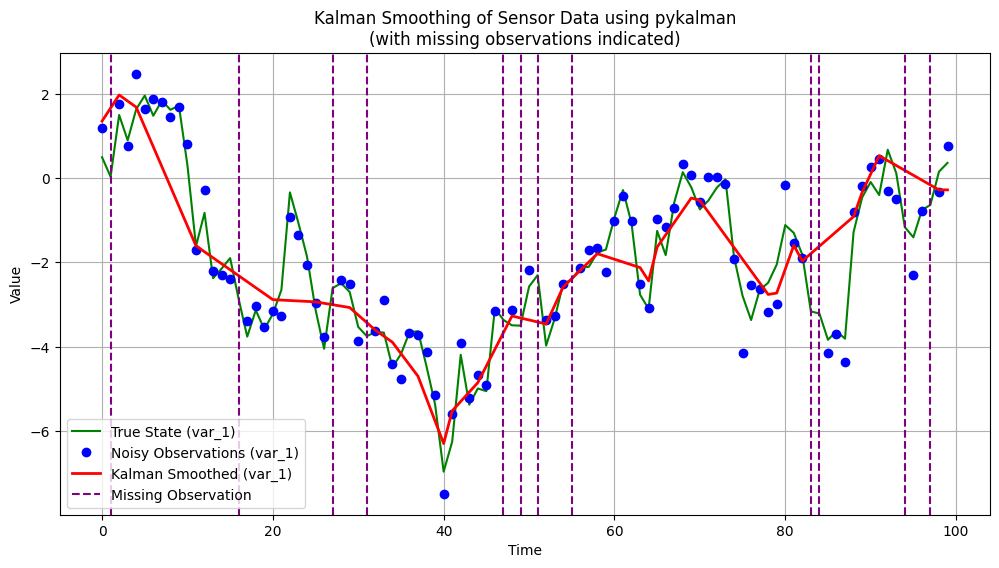

In [ ]:
# Step 5: Visualization for a Single Variable (e.g., var_1)
plt.figure(figsize=(12, 6))
plt.plot(df.index, true_state[:, 0], 'g-', label='True State (var_1)')
plt.plot(df.index, df['var_1'], 'bo', label='Noisy Observations (var_1)')
plt.plot(smoothed_df.index, smoothed_df['var_1'], 'r-', lw=2, label='Kalman Smoothed (var_1)')

# Identify the time points where the observation was missing (NaN)
missing_indices = df.index[df['var_1'].isna()]

# Plot a vertical dashed line at each missing observation.
# Use a single label for the first occurrence so the legend looks clean.
for i, mi in enumerate(missing_indices):
    if i == 0:
        plt.axvline(x=mi, color='purple', linestyle='--', linewidth=1.5, label='Missing Observation')
    else:
        plt.axvline(x=mi, color='purple', linestyle='--', linewidth=1.5)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Kalman Smoothing of Sensor Data using pykalman\n(with missing observations indicated)')
plt.legend()
plt.grid(True)
plt.show()



## Taming the Chaos: Kalman Filtering for Smoother Sensor Data

This notebook explored the power of Kalman filtering to refine noisy sensor data and intelligently handle missing observations. By simulating a realistic sensor environment and introducing deliberate data dropouts, we witnessed the filter's ability to extract meaningful insights from imperfect measurements.

Kalman-smoothed estimates closely tracked the underlying true state of our simulated system, even in the presence of noise and missing data. This demonstrates the filter's resilience and its potential to enhance the accuracy and reliability of sensor-based applications.

Whatever you are tracking, Kalman is a versatile tool for navigating the complexities of real-world data.
